In [1]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# get the accuracy metrics
from sklearn.metrics import r2_score
from mfbml.problems import MengCase1
from mfbml.methods.dnn_lr_bnn import DNNLinearRegressionBNN
from mfbml.methods.bayes_neural_nets import BNNWrapper
from mfbml.methods.dnn_bnn import DNNBNN

# fix the random seed for reproducibility
seed = 1999
np.random.seed(seed)
torch.manual_seed(seed)

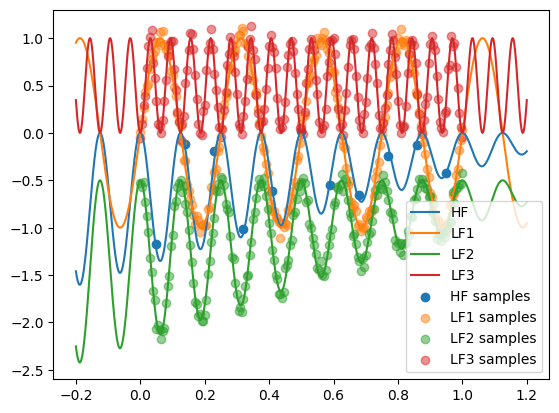

In [2]:
func = MengCase1(noise_std=0.0)
# generate samples (21 HF samples, 201 LF samples)
lf_samples = torch.linspace(0, 1, 201).reshape(-1, 1)
hf_samples = torch.linspace(0.05, 0.95, 11).reshape(-1, 1)
# add the end points

# training configure
samples = [hf_samples, lf_samples]

# generate responses
lf1_responses = func.lf1(lf_samples, noise_lf=0.05)
lf2_responses = func.lf2(lf_samples, noise_lf=0.05)
lf3_responses = func.lf3(lf_samples, noise_lf=0.05)
# get the high-fidelity responses
hf_responses = func.hf(hf_samples, noise_hf=0.05)
# generate the test points
test_samples = torch.linspace(-0.2, 1.2, 1001).reshape(-1, 1)
# noiseless responses
test_hf_responses_noiseless = func.hf(test_samples, noise_hf=0.0)
test_lf1_responses_noiseless = func.lf1(test_samples, noise_lf=0.0)
test_lf2_responses_noiseless = func.lf2(test_samples, noise_lf=0.0)
test_lf3_responses_noiseless = func.lf3(test_samples, noise_lf=0.0)
# noise responses
test_hf_responses = func.hf(test_samples, noise_hf=0.05)

# dataset of lf1 and hf
responses_lf1 = [hf_responses, lf1_responses]
# dataset of lf2 and hf
responses_lf2 = [hf_responses, lf2_responses]
# dataset of lf2 and hf
responses_lf3 = [hf_responses, lf3_responses]

# plot the function
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, test_lf1_responses_noiseless,   label="LF1")
ax.plot(test_samples, test_lf2_responses_noiseless,  label="LF2")
ax.plot(test_samples, test_lf3_responses_noiseless,  label="LF3")

# plot the samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf1_responses, alpha=0.5, label="LF1 samples")
ax.scatter(lf_samples, lf2_responses, alpha=0.5,  label="LF2 samples")
ax.scatter(lf_samples, lf3_responses, alpha=0.5, label="LF3 samples")

plt.legend()
# save the figure
# plt.savefig("sample_plan.png", dpi=300, bbox_inches="tight")
plt.show()

## Configurations for DNN and BNNs


In [3]:
# create the configuration of the low-fidelity model
lf_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "optimizer": "Adam",
    "lr": 0.001,
    "weight_decay": 0.000001,
    "loss": "mse",
}
# create the configuration of the high-fidelity model
hf_parallel_configure = {
    "in_features": 1,
    "hidden_features": [500, 500],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}
#
hf_sequential_configure = {
    "in_features": 2,
    "hidden_features": [500, 500],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}

# lf train config
lf_train_config = {
    "batch_size": None,
    "num_epochs": 10000,
    "print_iter": 100,
    "data_split": False,
}
hf_train_config = {
    "num_epochs": 2000,
    "sample_freq": 100,
    "print_info": True,
    "burn_in_epochs": 1000,
}

### train standard BNN using HF data


In [4]:
# normalize the responses
hf_responses_mean = hf_responses.mean().numpy()
hf_responses_std = hf_responses.std().numpy()
hf_responses_scaled = (hf_responses.clone() -
                       hf_responses_mean) / hf_responses_std

# create the sf_bnn model
sigma_scale = float(0.05 / hf_responses_std)
bnn_model = BNNWrapper(
    in_features=1,
    hidden_features=[500, 500],
    out_features=1,
    activation="Tanh",
    lr=0.001,
    sigma=sigma_scale,
)
# train the model
bnn_model.train(
    X=hf_samples,
    Y=hf_responses_scaled,
    num_epochs=2000,
    sample_freq=100,
    burn_in_epochs=1000,
)

/home/yaga/Documents/mfbml/src/mfbml/inference/psgld.py:108: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1581.)
  V.mul_(alpha).addcmul_(1 - alpha, d_p, d_p)


epoch:     0/ 2000
nll_loss: 284.000, prior_loss: 231829.719, total: 232113.719
noise: 0.131
epoch:   100/ 2000
nll_loss: 235.918, prior_loss: 266554.938, total: 266790.844
noise: 0.131
epoch:   200/ 2000
nll_loss: 216.971, prior_loss: 278409.469, total: 278626.438
noise: 0.131
epoch:   300/ 2000
nll_loss: 250.254, prior_loss: 288005.469, total: 288255.719
noise: 0.131
epoch:   400/ 2000
nll_loss: 138.503, prior_loss: 296362.094, total: 296500.594
noise: 0.131
epoch:   500/ 2000
nll_loss: 108.832, prior_loss: 304080.594, total: 304189.438
noise: 0.131
epoch:   600/ 2000
nll_loss: 55.437, prior_loss: 311315.781, total: 311371.219
noise: 0.131
epoch:   700/ 2000
nll_loss: 67.169, prior_loss: 318046.094, total: 318113.250
noise: 0.131
epoch:   800/ 2000
nll_loss: 70.688, prior_loss: 324078.344, total: 324149.031
noise: 0.131
epoch:   900/ 2000
nll_loss: 10.663, prior_loss: 329645.750, total: 329656.406
noise: 0.131
epoch:  1000/ 2000
nll_loss: 55.619, prior_loss: 335240.625, total: 335296

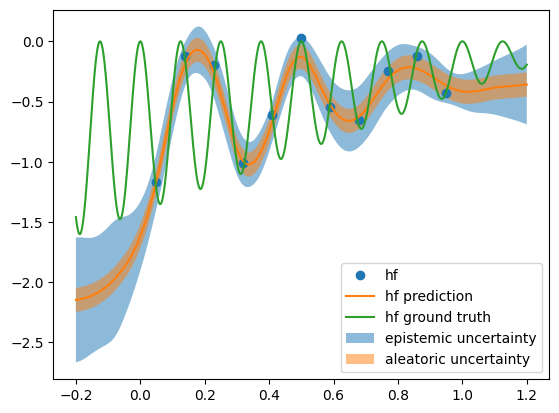

In [5]:
# visualize the posterior of bnn
(bnn_y,
 bnn_epistemic,
 bnn_total_unc,
 bnn_aleatoric) = bnn_model.predict(
    X=test_samples)
# scale the prediction
bnn_y = bnn_y * hf_responses_std + hf_responses_mean
bnn_total_unc = bnn_total_unc * hf_responses_std
bnn_epistemic = bnn_epistemic * hf_responses_std
bnn_aleatoric = bnn_aleatoric * hf_responses_std

# plot
plt.figure()
plt.plot(hf_samples, hf_responses, "o", label="hf")
plt.plot(test_samples.numpy(), bnn_y, label="hf prediction")

plt.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
# plt.fill_between(
#     test_samples.flatten().numpy(),
#     (bnn_y - 2 * bnn_total_unc).reshape(-1),
#     (bnn_y + 2 * bnn_total_unc).reshape(-1),
#     alpha=0.5,
#     label="uncertainty",
# )
# plot the episitmic uncertainty
plt.fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_epistemic).reshape(-1),
    (bnn_y + 2 * bnn_epistemic).reshape(-1),
    alpha=0.5,
    label="epistemic uncertainty",
)
# plot aleatoric uncertainty
plt.fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_aleatoric).reshape(-1),
    (bnn_y + 2 * bnn_aleatoric).reshape(-1),
    alpha=0.5,
    label="aleatoric uncertainty",
)
plt.legend()
plt.show()

# training of sequential MF-DNN-BNN model


In [6]:
# sequential mf-bnn
smf_bnn_lf1 = DNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)

smf_bnn_lf1.train(
    X=samples,
    Y=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.9557971954345703
epoch:  200 train loss:  0.9555481672286987
epoch:  300 train loss:  0.9552602171897888
epoch:  400 train loss:  0.9549012184143066
epoch:  500 train loss:  0.9543620944023132
epoch:  600 train loss:  0.9532973170280457
epoch:  700 train loss:  0.9485248923301697
epoch:  800 train loss:  0.9106639623641968
epoch:  900 train loss:  0.8463836312294006
epoch:  1000 train loss:  0.6128884553909302
epoch:  1100 train loss:  0.3656408190727234
epoch:  1200 train loss:  0.09635227918624878
epoch:  1300 train loss:  0.042358964681625366
epoch:  1400 train loss:  0.03569015488028526
epoch:  1500 train loss:  0.030373290181159973
epoch:  1600 train loss:  0.0243757925927639
epoch:  1700 train loss:  0.017931818962097168
epoch:  1800 train loss:  0.012671861797571182
epoch:  1900 train loss:  0.009693062864243984
epoch:  2000 train loss:  0.00801079347729683
epoch:  2100 train loss:  0.0069951205514371395
epoch: 

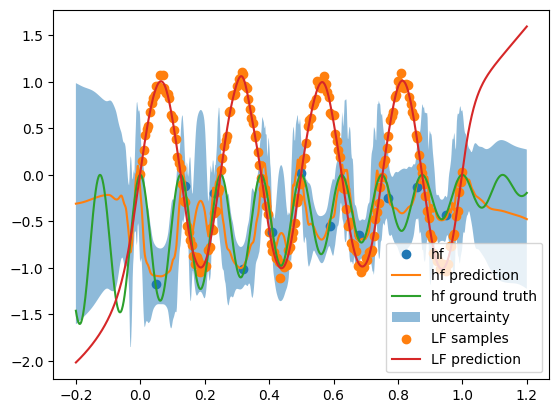

In [7]:
# visualize the posterior of sequential mf-bnn
(
    smf_bnn_lf1_hy,
    smf_bnn_lf1_epistemic,
    smf_bnn_lf1_total_unc,
    smf_bnn_lf1_aleatoric,
) = smf_bnn_lf1.predict(X=test_samples)
# get lf predictions
smf_bnn_lf1_y = smf_bnn_lf1.predict_lf(X=test_samples, output_format="numpy")
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), smf_bnn_lf1_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf1_hy - 2 * smf_bnn_lf1_total_unc).reshape(-1),
    (smf_bnn_lf1_hy + 2 * smf_bnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)

# plot lf samples
ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(
    test_samples.numpy(),
    smf_bnn_lf1_y,
    label="LF prediction"
)
ax.legend()
plt.show()

In [8]:
# create the MFDNNBNN object
mfdnnbnn_lf1 = DNNLinearRegressionBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=True,
    lf_order=2,
    beta_bounds=[-5, 5],
    optimizer_restart=20,
    discrepancy_normalization="diff",
)

In [9]:
# define beta
mfdnnbnn_lf1.train(
    X=samples,
    Y=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.9557936787605286
epoch:  200 train loss:  0.9554874300956726
epoch:  300 train loss:  0.9551032781600952
epoch:  400 train loss:  0.9545162320137024
epoch:  500 train loss:  0.9532241225242615
epoch:  600 train loss:  0.9473689198493958
epoch:  700 train loss:  0.9067025780677795
epoch:  800 train loss:  0.8615824580192566
epoch:  900 train loss:  0.7916892766952515
epoch:  1000 train loss:  0.6486616730690002
epoch:  1100 train loss:  0.44257068634033203
epoch:  1200 train loss:  0.12075337767601013
epoch:  1300 train loss:  0.02691453881561756
epoch:  1400 train loss:  0.016505945473909378
epoch:  1500 train loss:  0.010168500244617462
epoch:  1600 train loss:  0.006877809762954712
epoch:  1700 train loss:  0.005487262271344662
epoch:  1800 train loss:  0.0049003129824995995
epoch:  1900 train loss:  0.004603811539709568
epoch:  2000 train loss:  0.004424863960593939
epoch:  2100 train loss:  0.0043082283809781075
ep

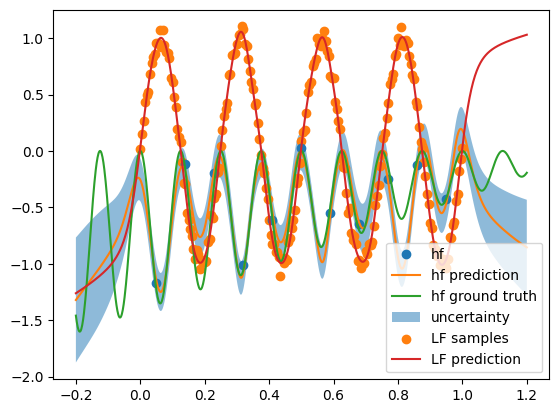

In [10]:
# visualize the posterior of mf-dnn-bnn
(
    mfdnnbnn_lf1_hy,
    mfdnnbnn_lf1_epistemic,
    mfdnnbnn_lf1_total_unc,
    mfdnnbnn_lf1_aleatoric,
) = mfdnnbnn_lf1.predict(X=test_samples)
# get lf predictions
mfdnnbnn_lf1_y = mfdnnbnn_lf1.predict_lf(X=test_samples, output_format="numpy")

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), mfdnnbnn_lf1_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_hy - 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    (mfdnnbnn_lf1_hy + 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(test_samples.numpy(), mfdnnbnn_lf1_y,
        label="LF prediction")
ax.legend()
plt.show()

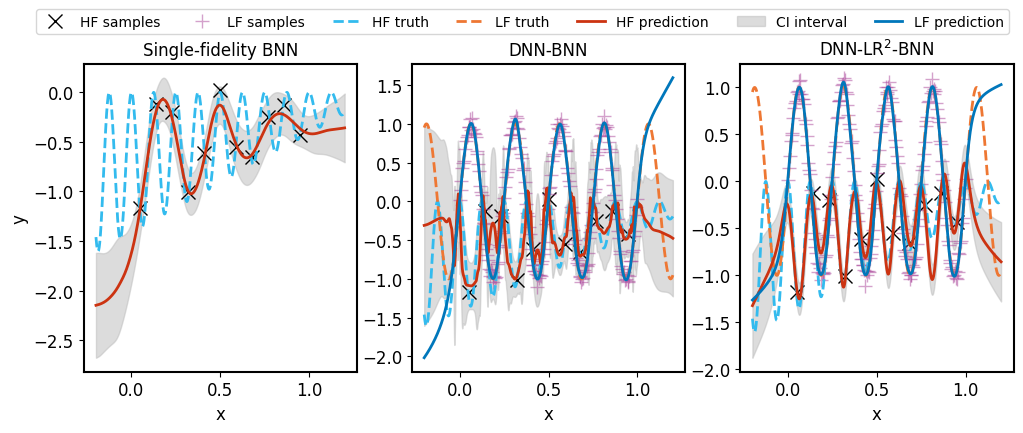

In [32]:
# plot the figures together
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
# plot the results of single-fidelity BNN
ax[0].plot(hf_samples,
           hf_responses,
           "kx",
           linewidth=2,
           markersize=10, label="HF samples")
ax[0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
ax[0].plot(test_samples.numpy(), bnn_y, "-",
           color="#CC3311",
           linewidth=2,
           label="HF prediction",)

ax[0].fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_total_unc).reshape(-1),
    (bnn_y + 2 * bnn_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# ax[0].legend()
ax[0].set_title("Single-fidelity BNN")

# plot the results of sequential mf-bnn
ax[1].plot(hf_samples,
           hf_responses,
           "kx",
           linewidth=2,
           markersize=10,
           label="HF samples",
           )
ax[1].plot(lf_samples,
           lf1_responses,
           "+",
           color="#AA4499",
           linewidth=2,
           markersize=10,
           alpha=0.5,
           label="LF samples",)
ax[1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
ax[1].plot(
    test_samples.numpy(),
    test_lf1_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)
ax[1].plot(test_samples.numpy(), smf_bnn_lf1_hy, "-",
           color="#CC3311",
           linewidth=2,
           label="HF prediction",)

ax[1].fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf1_hy - 2 * smf_bnn_lf1_total_unc).reshape(-1),
    (smf_bnn_lf1_hy + 2 * smf_bnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

ax[1].plot(test_samples.numpy(), smf_bnn_lf1_y, "-", color="#0077BB",
           linewidth=2,
           label="LF prediction",)
ax[1].set_title("DNN-BNN")


# plot the results of mf-dnn-bnn
ax[2].plot(hf_samples,
           hf_responses,
           "kx",
           linewidth=2,
           markersize=10,
           label="HF samples",
           )
ax[2].plot(lf_samples,
           lf1_responses,
           "+",
           color="#AA4499",
           linewidth=2,
           markersize=10,
           alpha=0.5,
           label="LF samples",)
ax[2].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
ax[2].plot(
    test_samples.numpy(),
    test_lf1_responses_noiseless.numpy(),
    "--",
    color="#EE7733",
    linewidth=2,
    label="LF truth",
)
ax[2].plot(test_samples.numpy(), mfdnnbnn_lf1_hy, "-",
           color="#CC3311",
           linewidth=2,
           label="HF prediction",)
# plot lf predictions
ax[2].plot(test_samples.numpy(), mfdnnbnn_lf1_y, "-", color="#0077BB",
           linewidth=2,
           label="LF prediction",)

ax[2].fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_hy - 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    (mfdnnbnn_lf1_hy + 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# set title
ax[2].set_title(r"DNN-LR$^2$-BNN")
# set the legend
ax[1].legend(loc='upper left', bbox_to_anchor=(-1.4, 1.2), fontsize=10,
                 frameon=True, ncol=7)

# set the linewidth of the frame
for i in range(3):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[i].spines[axis].set_linewidth(1.5)
# set the fontsize of the ticks
for i in range(3):
    ax[i].tick_params(axis='both', which='major', labelsize=12)
# set the x and y label
for i in range(3):
    if i == 0:
        ax[i].set_ylabel("y", fontsize=12)
    ax[i].set_xlabel("x", fontsize=12)
# save the figure
plt.savefig("mf_bnn.png", dpi=300, bbox_inches="tight")
plt.show()